In [1]:
import tensorflow as tf
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

import tensorflow as tf
from tools.analyzer import Distance
import tools.analyzer as ana


%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('train')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz


In [3]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/visit-1"

seed = None

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [4]:
import tensorflow as tf

graph = tf.Graph()


with graph.as_default():
    
    model = semisup.SemisupModel(arch.mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    # iterator = up.create_input(train_images, train_labels, unsup_batch_size)
    # t_unsup_images, _ = up.create_input(train_images, train_labels, unsup_batch_size)
    
    #it = up.create_input(train_images, train_labels, unsup_batch_size)
    #t_unsup_images,_ = it.get_next()
    
    unsup_data = up.create_input(train_images, train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,_ = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    #t_sup_images, t_sup_labels = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [5]:

def get_embedded(train_step, model_checkpoint):
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
    
    stacked = np.vstack((embedded_sup, embedded_sup))
        
    return embedded_sup#stacked

def get_similarity(stacked, dist_func):
    
    similarity = ana.get_pairwise_distance(
        stacked, 
        dist_func
    )
    return similarity

def retrieve_similarity(train_step, model_checkpoint, dist_func):
    stacked = get_embedded(train_step, model_checkpoint)   
    return get_similarity(stacked, dist_func)
    
dist_func = Distance.l1
similarities = []
labels = []
similarities.append(retrieve_similarity(100, "logs/visit-1-", dist_func))
labels.append(100)
similarities.append(retrieve_similarity(500, "logs/visit-1-", dist_func))
labels.append(500)
similarities.append(retrieve_similarity(1000, "logs/visit-1-", dist_func))
labels.append(1000)
similarities.append(retrieve_similarity(2000, "logs/visit-1-", dist_func))
labels.append(2000)

INFO:tensorflow:Restoring parameters from logs/visit-1-100
INFO:tensorflow:Restoring parameters from logs/visit-1-500
INFO:tensorflow:Restoring parameters from logs/visit-1-1000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


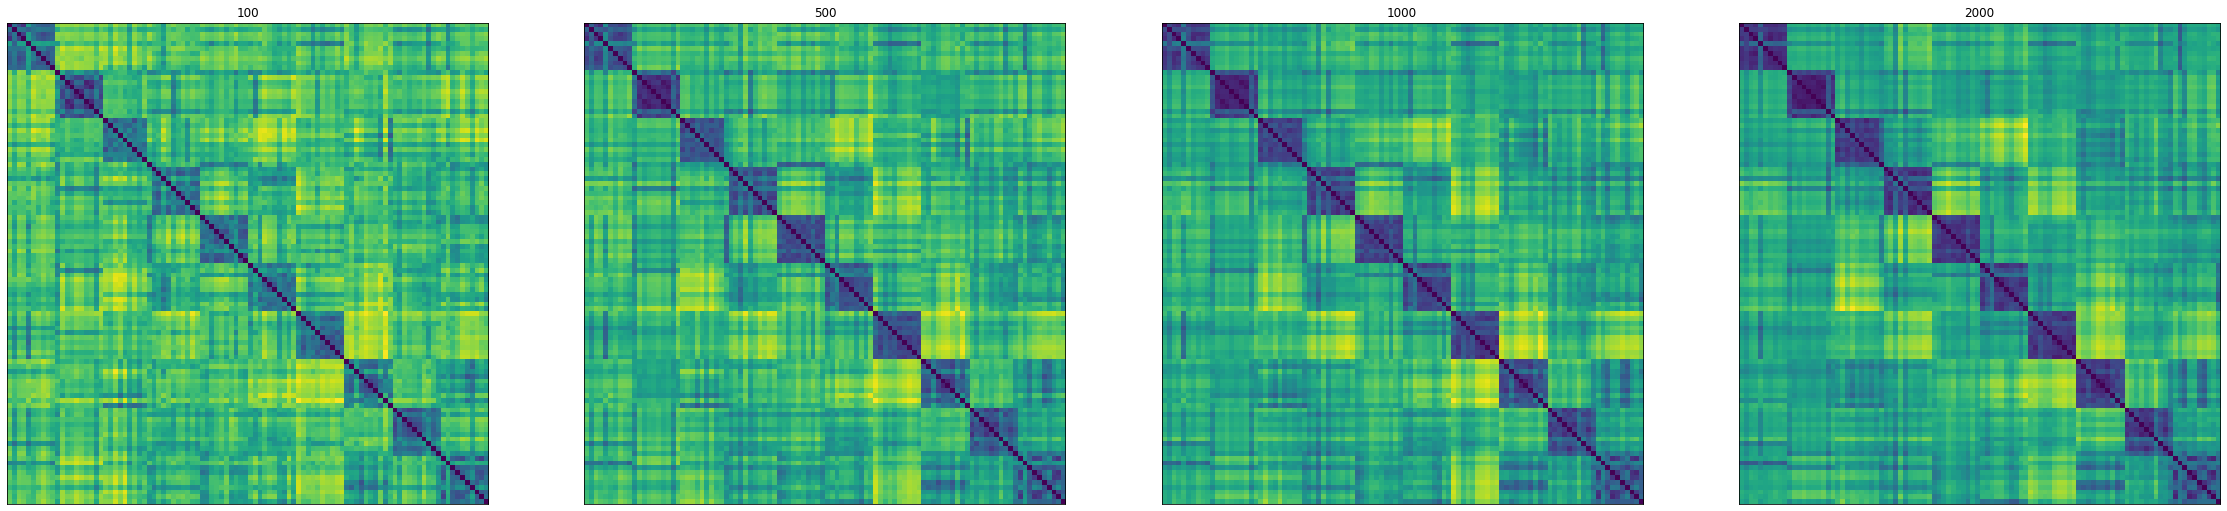

In [6]:
vis.imshow(similarities, figsize=(50,50), labels=labels, imgwidth=100)

In [24]:
similarities = []
labels = []
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.k_dot))
labels.append("k_dot")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_gaussian_k(2)))
labels.append("gaussian s=2")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_gaussian_k(4)))
labels.append("gaussian s=4")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_pseudo_gaussian_k(2)))
labels.append("pseudo gaussian s=4")


INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


In [25]:
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_polynomial_k(bias=0, exponent=1)))
labels.append("poly b=0,exp=1")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_polynomial_k(bias=10, exponent=1)))
labels.append("poly b=10,exp=1")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_polynomial_k(bias=0, exponent=2)))
labels.append("poly b=0,exp=2")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_polynomial_k(bias=10, exponent=10)))
labels.append("poly b=0,exp=10")
similarities.append(retrieve_similarity(2000, "logs/visit-1-", Distance.get_polynomial_k(bias=10, exponent=0.3)))
labels.append("poly b=0,exp=0.3")

INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


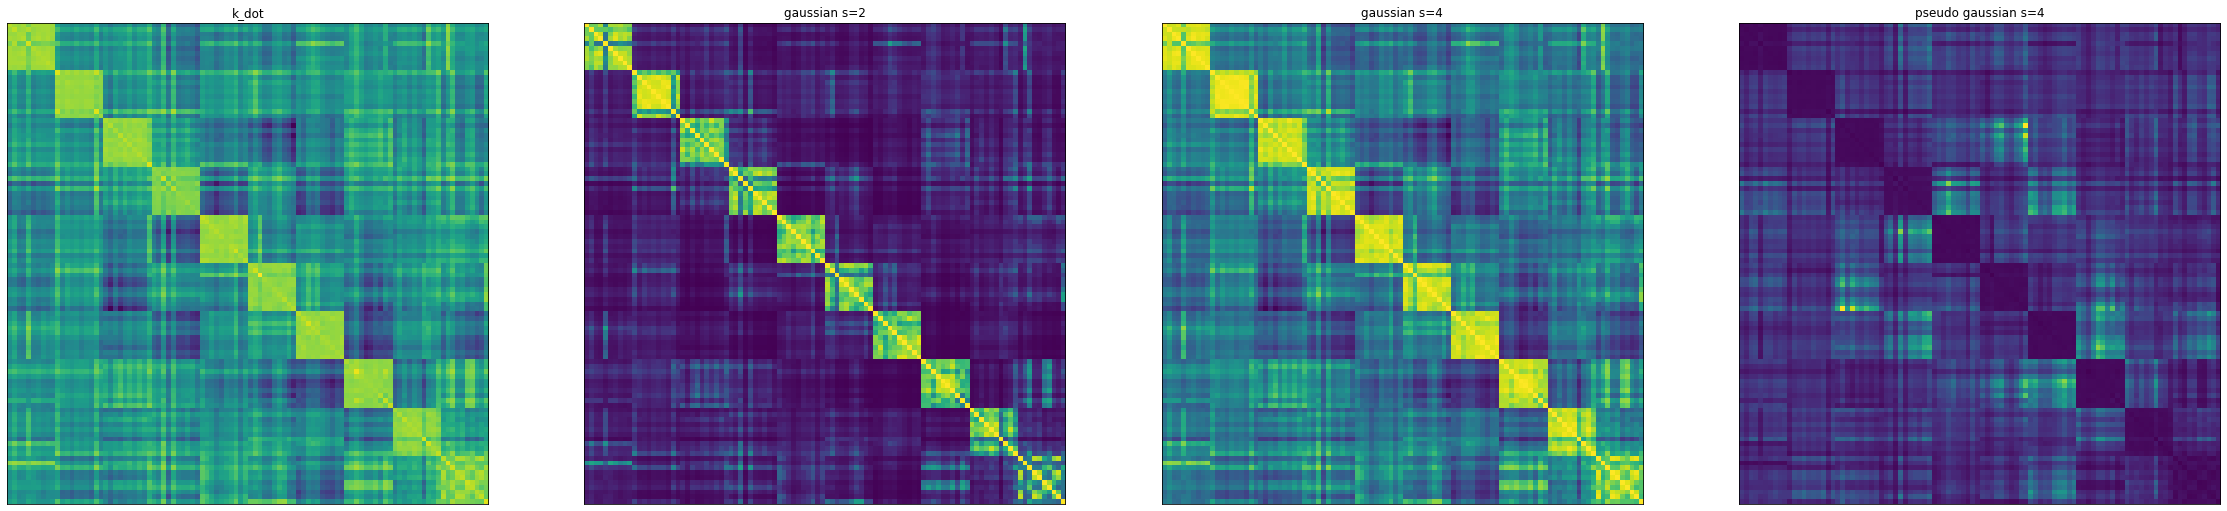

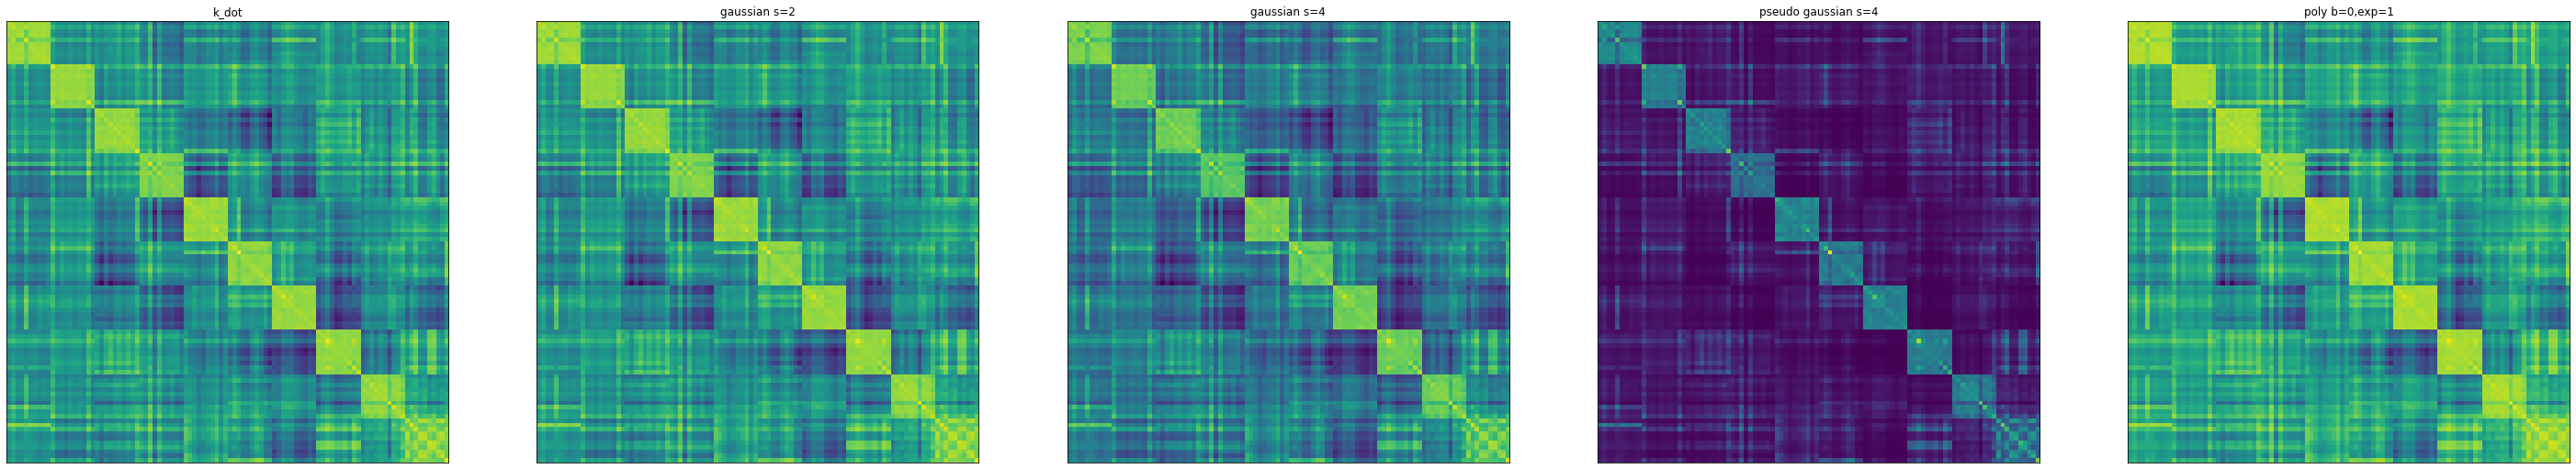

In [26]:
vis.imshow(similarities[:4], figsize=(50,50), labels=labels, imgwidth=100)
vis.imshow(similarities[4:], figsize=(50,50), labels=labels, imgwidth=100)